# 분류 - 영화추천
## #01. 패키지 참조



In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os

## #02. 데이터 가져오기

### 주피터에서 현재 디렉토리 가져오기

In [3]:
print(os.getcwd())

c:\Users\Hamin\Mega_Data_Analysis\F. 데이터 마이닝\02.sklaern


### 영화데이터 

In [4]:


origin_mv = pd.read_csv('c:\\Users\\Hamin\\Mega_Data_Analysis\\F. 데이터 마이닝\\02.sklaern\\netflix\\Netflix_Dataset_Movie.csv',encoding='utf-8')



### 영화 별점 데이터


In [5]:

origin_rating = pd.read_csv('c:\\Users\\Hamin\\Mega_Data_Analysis\\F. 데이터 마이닝\\02.sklaern\\netflix\\Netflix_Dataset_Rating.csv',encoding='utf-8')



In [6]:
gdf = origin_rating[['Movie_ID','User_ID']].groupby('Movie_ID').count().sort_values("User_ID",ascending=False)
gdf.head()

,User_ID
Movie_ID,
1905,117075
2452,102721
4306,102376
571,101450
3860,98545


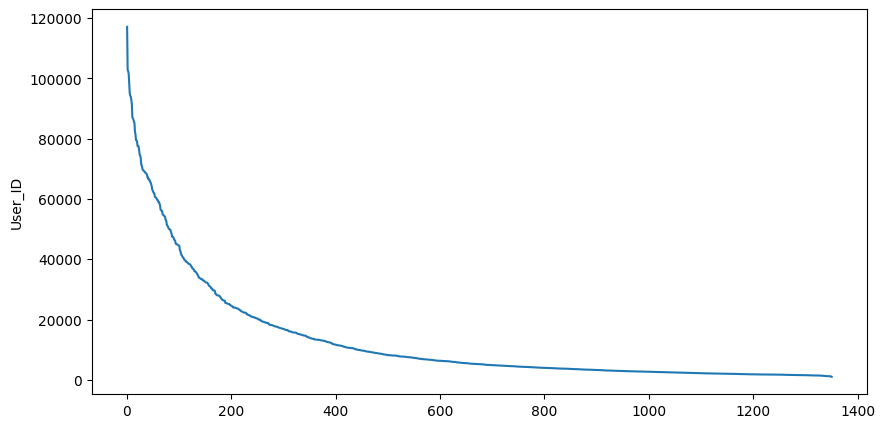

In [7]:
plt.figure(figsize=(10,5))
sb.lineplot(data=gdf, y='User_ID', x=range(1, len(gdf.index)+1))
plt.show()
plt.close()

## #03. 데이터 전처리
### 별점 데이터 재배치 (피벗테이블)


In [8]:
fav_movie_df = gdf.loc[gdf['User_ID']>80000,:].dropna()
fav_movie_df

,User_ID
Movie_ID,
1905,117075
2452,102721
4306,102376
571,101450
3860,98545
2862,95053
3962,94235
4432,93886
3938,92893


In [9]:
rating_df = origin_rating[origin_rating['Movie_ID'].isin(fav_movie_df.index)]
rating_df

,User_ID,Rating,Movie_ID
2184894,1734805,3,571
2184895,364518,4,571
2184896,1392773,5,571
2184897,716091,5,571
2184898,1527030,5,571
...,...,...,...
17163696,480064,3,4432
17163697,666284,5,4432
17163698,1462398,5,4432
17163699,158902,5,4432


### 별점 데이터 재구조화

각 영화를 칼럼으로, 사용자 번호를 인덱스로 하는 피벗 테이블을 구성한다. 

In [10]:
pivot_rating = pd.pivot(rating_df,index = 'User_ID',columns='Movie_ID',values='Rating')
pivot_rating

Movie_ID,571,1180,1905,1962,2152,2372,2452,2782,2862,3106,3427,3624,3860,3938,3962,4306,4432
User_ID,,,,,,,,,,,,,,,,,
6,NaN,3.0,4.0,4.0,3.0,5.0,5.0,5.0,4.0,NaN,4.0,4.0,3.0,4.0,4.0,4.0,3.0
7,4.0,5.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,5.0,5.0
79,NaN,4.0,4.0,5.0,3.0,4.0,4.0,4.0,4.0,NaN,4.0,1.0,2.0,5.0,5.0,5.0,4.0
97,3.0,5.0,4.0,NaN,3.0,NaN,5.0,NaN,NaN,5.0,2.0,NaN,NaN,NaN,NaN,5.0,NaN
134,4.0,NaN,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,5.0,4.0,4.0,4.0,NaN,3.0,5.0,5.0,NaN,NaN,NaN,4.0,4.0,4.0,4.0,NaN,NaN
2649378,5.0,5.0,4.0,NaN,4.0,4.0,3.0,4.0,5.0,4.0,NaN,3.0,2.0,4.0,4.0,4.0,3.0
2649388,3.0,4.0,2.0,4.0,4.0,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN


#### 결측치 처리

In [11]:
pivot_rating.fillna(0,inplace=True)
pivot_rating

Movie_ID,571,1180,1905,1962,2152,2372,2452,2782,2862,3106,3427,3624,3860,3938,3962,4306,4432
User_ID,,,,,,,,,,,,,,,,,
6,0.0,3.0,4.0,4.0,3.0,5.0,5.0,5.0,4.0,0.0,4.0,4.0,3.0,4.0,4.0,4.0,3.0
7,4.0,5.0,5.0,5.0,3.0,4.0,5.0,5.0,5.0,4.0,3.0,5.0,4.0,4.0,5.0,5.0,5.0
79,0.0,4.0,4.0,5.0,3.0,4.0,4.0,4.0,4.0,0.0,4.0,1.0,2.0,5.0,5.0,5.0,4.0
97,3.0,5.0,4.0,0.0,3.0,0.0,5.0,0.0,0.0,5.0,2.0,0.0,0.0,0.0,0.0,5.0,0.0
134,4.0,0.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,5.0,4.0,4.0,4.0,0.0,3.0,5.0,5.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,0.0,0.0
2649378,5.0,5.0,4.0,0.0,4.0,4.0,3.0,4.0,5.0,4.0,0.0,3.0,2.0,4.0,4.0,4.0,3.0
2649388,3.0,4.0,2.0,4.0,4.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0


## #04. 분류 모델 구축

### 단일 수행

아니그러면 x가 평점이고, y가 유저아이디 , 평점을 기준으로 영화를 분류한다는 건가


In [12]:
k=5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(pivot_rating.values,pivot_rating.index)
y_pred = knn.predict(pivot_rating.values)
y_pred

MemoryError: Unable to allocate 153. GiB for an array with shape (143163, 143163) and data type float64

In [13]:
# from sklearn.metrics import accuracy_score

In [21]:
# x

User_ID,6,7,79,97,134,169,183,188,195,199,...,2649308,2649328,2649331,2649335,2649336,2649370,2649378,2649388,2649426,2649429
Movie_ID,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0
4490,0.0,0.0,4.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
y

Index([   3,    8,   16,   17,   18,   26,   28,   30,   32,   33,
       ...
       4472, 4474, 4478, 4479, 4485, 4488, 4490, 4492, 4493, 4496],
      dtype='int64', name='Movie_ID', length=1350)

In [23]:
k=5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(x,y)
y_pred = knn.predict(x.values)
score = accuracy_score(y,y_pred)
print(score)

0.1711111111111111


### 교차검증 적용


In [24]:
import numpy as np 

In [30]:
k_num = range(1,len(x.columns)-1)
k_scores=[]

for k in k_num :
    knn = KNeighborsClassifier(n_neighbors=k)
    # score = cross_val_score(knn,x,y,cv=5).max()
    knn.fit(x,y)
    y_pred = knn.predict(x.values)
    score = accuracy_score(y,y_pred)
    if np.isnan(score) :
        break
    k_scores.append(score)

k_scores


KeyboardInterrupt: 